## Testing GWA on stochastic block model networks

In this notebook, we show how GWA can be used to simplify an asymmetric, weighted, stochastic block model (SBM) network. 

In [1]:
# Import packages
import scipy as sp
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import ot
import time
from ot.bregman import sinkhorn
from ot.utils import dist
from ot.optim import cg
import gromovWassersteinAveraging as gwa
from sklearn import manifold
from sklearn.cluster import KMeans
import pandas as pd

import os 
from os.path import dirname, join as pjoin
import scipy.io as sio

# For easy editing
%load_ext autoreload
%autoreload 2

In [2]:
simpleNets = sio.loadmat("simpleNets.mat")
simpleNets_prob = sio.loadmat("simpleNets_prob.mat")


simpleNets = simpleNets['simpleNets']
simpleNets_prob = simpleNets_prob['simpleNets_prob']

simpleNets = simpleNets[0]
simpleNets_prob = simpleNets_prob[0]

In [85]:
sbms = sio.loadmat("sbms.mat")
sbmprobs = sio.loadmat("sbmprobs.mat")

sbms = sbms['sbms']
sbmprobs = sbmprobs['sbmprobs']

In [89]:
A= sbms[3][0]
pA = sbmprobs[3][0]
print(A.shape)
print(pA.shape)

(50, 50)
(50, 1)


Now we load an SBM and plot it.

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


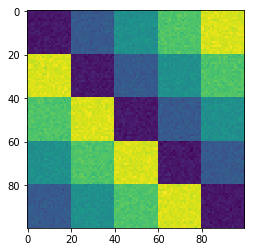

In [91]:
# 100 x 100 SBM network
A = sbms[21][0]
pA = sbmprobs[21][0]
pA = np.squeeze(pA)

fig = plt.figure()
plt.imshow(A)


B = np.zeros((5,5))
pB = ot.unif(5)
print(B)


Some info from the generation procedure: the blocks in A correspond to numbers 0, 25, 50, 75, 100, sampled with a fixed variance of 5. Here is what A looks like:

In [92]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame(A))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3.829173,-0.046214,1.575670,1.162150,1.326696,1.325822,-0.918143,-3.316314,1.880848,-0.708285,3.139146,-0.536334,-1.450733,-0.650999,2.813558,-1.009956,0.676849,1.868414,0.291596,1.928867,24.824754,26.179224,25.760045,23.001072,27.741190,23.082459,29.979334,24.906277,26.068734,28.652209,25.160319,22.566565,23.854663,20.554854,22.662010,25.265431,25.139816,27.773757,27.991697,25.930552,51.594928,49.482037,47.806554,47.209494,48.749142,51.549336,44.438111,49.451265,53.331494,50.073261,47.368436,52.052242,52.041918,51.645075,53.817623,50.224125,47.081658,50.533693,51.213927,50.651164,76.090400,74.821685,76.614803,70.604339,77.173871,74.955823,79.860455,75.723455,74.826025,76.185249,74.176091,76.448720,74.960948,76.448140,72.226437,75.018870,74.729891,74.596091,73.749373,70.106831,100.968924,102.036993,104.481938,99.723476,99.710632,96.689435,101.736032,98.184345,101.331951,97.677901,103.734319,98.257383,100.191036,99.683829,99.859462,101.521403,101.510684,99.273275,98.326208,98.151398
1,1.495872,0.091005,1.876041,0.391267,-1.973706,-0.699165,-0.152408,-1.279130,0.003916,1.278944,-2.431046,1.501494,-0.397029,1.240998,2.110335,-0.293897,1.473701,2.320408,3.988135,-0.434614,27.647621,24.591725,25.737851,21.459225,21.256236,23.459737,22.072955,22.874413,26.172460,23.064413,21.867784,19.236407,21.461927,22.052442,24.782695,26.418344,24.050765,24.083806,22.853544,20.328974,45.926196,50.415156,49.573115,48.942956,54.821700,50.655978,48.034031,48.187851,51.339172,49.130868,46.998565,51.088946,43.535689,49.679275,51.127042,49.214605,50.674728,46.336645,49.131581,50.969499,73.544235,78.562787,75.516694,76.985634,72.357574,74.971874,77.514626,71.972336,74.723048,74.058203,75.767378,73.723685,78.566780,74.841277,77.843748,74.466983,76.982845,76.500553,74.904371,75.120384,97.557891,96.908391,95.705134,99.666732,97.601368,97.979086,104.422506,100.022494,97.752529,98.050763,103.139879,100.510093,100.458168,98.075709,101.289303,97.286443,100.954656,96.908391,96.094534,100.064397
2,-1.755745,-1.642375,0.808038,-1.878669,-2.150226,1.506846,0.337119,2.381979,1.526762,-3.910379,0.884464,1.699917,-1.035396,-0.913344,-2.686847,-0.281709,0.523243,1.136231,1.988713,1.167525,24.870868,23.767608,25.586787,23.620972,21.664793,27.732927,23.164336,29.127553,26.415261,25.587018,27.294993,26.122084,24.786342,24.427562,22.437116,22.712980,27.672638,23.555483,28.627344,27.358035,52.060545,48.778711,51.347148,49.508737,47.394072,47.962768,49.988297,44.802627,47.904632,49.372661,47.953593,48.602032,51.158009,49.450860,50.617404,49.439089,49.843598,49.250289,51.040646,45.377671,76.137292,75.467890,70.805203,74.177056,74.739684,75.295811,74.649067,71.259511,74.436584,80.826700,78.608509,75.237986,79.243117,77.604757,74.096592,75.564435,76.798208,74.204981,70.863103,76.417794,102.216979,99.957797,100.560321,100.876503,101.448681,103.560457,98.855530,104.221777,99.403665,102.668341,100.631005,99.343044,99.537114,99.050520,98.442670,100.707425,98.240134,96.258225,99.769334,102.715069
3,-2.478813,1.046244,-2.356290,-1.660819,0.555695,-3.410729,0.315868,-1.485877,3.039390,1.080811,-0.382190,0.975502,-4.676103,2.326832,0.794054,1.064480,2.684803,-0.414409,-1.583003,-0.328129,24.087731,22.376458,25.514852,24.724988,26.868067,26.951847,28.265227,25.067403,23.096572,22.983342,20.846710,28.692075,24.079706,21.120224,26.580046,22.001060,26.643435,28.362697,28.886980,24.622821,50.516467,54.704377,46.632723,52.984527,50.402690,47.440732,51.911800,46.617863,50.965270,50.847493,47.503130,52.878313,49.866308,48.930693,52.555087,50.447837,49.394866,52.442992,48.995509,46.698615,74.222926,73.848518,79.259245,74.238773,75.837968,77.866850,71.824315,73.516122,71.829165,77.477612,73.943501,78.916097

B is a "zero network". Let's see what we get when we average them, but without allowing expansion. In other words, we are looking for the best 5 x 5 representation of A (we know that this "ground truth" simplified representation exists).

In [93]:
CList = [B,A]
pList = [pB,pA]


avg, Deltas, Frechet_Loss = gwa.network_karcher_mean_armijo_sched_compress(B,pB,CList,pList,budget=5,exploreIter = 20, maxIter = 30)

Iter Frechet_Loss
0 1763040.697849646
current size  (5, 5)
1 467877.24765540945  full gradient step
current size  (5, 5)
2 326985.12626120483  full gradient step
current size  (5, 5)
3 326985.126261205  full gradient step
current size  (5, 5)
4 326985.12626120495  full gradient step
current size  (5, 5)
5 326985.1262612049  full gradient step
current size  (5, 5)
6 326985.126261205  full gradient step
current size  (5, 5)
7 326985.12626120506  full gradient step
current size  (5, 5)
8 326985.12626120495  full gradient step
current size  (5, 5)
9 326985.1262612049  full gradient step
current size  (5, 5)
10 326985.126261205  full gradient step
current size  (5, 5)
11 326985.12626120506  full gradient step
current size  (5, 5)
12 326985.12626120495  full gradient step
current size  (5, 5)
13 326985.1262612049  full gradient step
current size  (5, 5)
14 326985.126261205  full gradient step
current size  (5, 5)
15 326985.12626120506  full gradient step
current size  (5, 5)
16 326985.126261

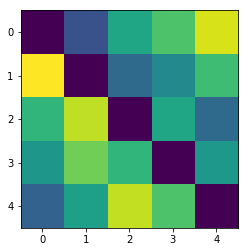

In [94]:
fig = plt.figure()
plt.imshow(avg)

We can 'eyeball' a permutation that makes the first row of the average looke like the first row of $A$. This is the permutation represented by the matrix:

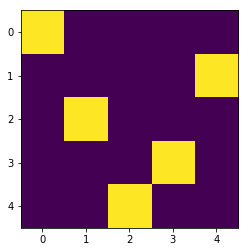

In [95]:
Perm = np.array([[1,0,0,0,0],[0,0,0,0,1],[0,1,0,0,0],[0,0,0,1,0],[0,0,1,0,0]])

plt.imshow(Perm);

Act on `avg` by this permutation matrix. 

In [96]:
avg2 = np.matmul(Perm,np.matmul(avg,np.transpose(Perm)))

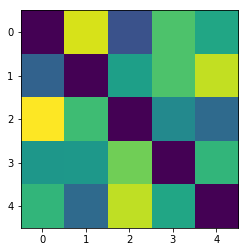

In [97]:
fig = plt.figure()
plt.imshow(avg2)

In [98]:
display(pd.DataFrame(avg2))

,0,1,2,3,4
0,-0.012439,46.864370,12.477124,36.058299,29.556053
1,15.617231,-0.069665,28.224508,35.914601,45.262684
2,49.931719,34.332074,0.018371,23.472827,17.195541
3,26.469599,26.583301,39.028478,-0.036423,32.916512
4,32.904867,17.287827,45.209308,29.581431,-0.069835


Thus we obtain a 5x5 network that is an average of A and B.

#### The effect of the seed point on compression

Notice that we had set a budget of 5 before. If the log map requests a blow-up with size exceedind the budget, the code decides not to blow-up, but to perform an averaging step instead. However, if we're at a network that already exceeds the budget, we do not perform any more compression. So in the previous example, it was important to start at the 5-node network. Here is an example of what happens if we had started at the 100-node network.

In [105]:
# starting at 100-node network

avg3, Deltas, Frechet_Loss = gwa.network_karcher_mean_armijo_sched_compress(A,pA,CList,pList,budget=5,exploreIter = 20, maxIter = 30)

Iter Frechet_Loss
0 1763040.6978496457
current size  (100, 100)
1 220380.08723179615  full gradient step
current size  (100, 100)
2 220380.08723179615  full gradient step
current size  (100, 100)
3 220380.08723179615  full gradient step
current size  (100, 100)
4 220380.08723179615  full gradient step
current size  (100, 100)
5 220380.08723179615  full gradient step
current size  (100, 100)
6 220380.08723179615  full gradient step
current size  (100, 100)
7 220380.08723179615  full gradient step
current size  (100, 100)
8 220380.08723179615  full gradient step
current size  (100, 100)
9 220380.08723179615  full gradient step
current size  (100, 100)
10 220380.08723179615  full gradient step
current size  (100, 100)
11 220380.08723179615  full gradient step
current size  (100, 100)
12 220380.08723179615  full gradient step
current size  (100, 100)
13 220380.08723179615  full gradient step
current size  (100, 100)
14 220380.08723179615  full gradient step
current size  (100, 100)
15 2203

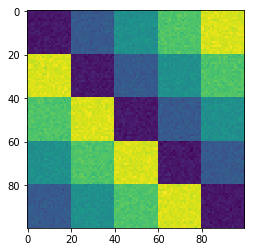

In [106]:
fig = plt.figure()
plt.imshow(avg3)

In [107]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame(avg3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1.914587,-0.023107,0.787835,0.581075,0.663348,0.662911,-0.459072,-1.658157,0.940424,-0.354142,1.569573,-0.268167,-0.725367,-0.325499,1.406779,-0.504978,0.338424,0.934207,0.145798,0.964433,12.412377,13.089612,12.880023,11.500536,13.870595,11.541229,14.989667,12.453139,13.034367,14.326104,12.580160,11.283283,11.927331,10.277427,11.331005,12.632716,12.569908,13.886879,13.995848,12.965276,25.797464,24.741018,23.903277,23.604747,24.374571,25.774668,22.219055,24.725633,26.665747,25.036630,23.684218,26.026121,26.020959,25.822537,26.908811,25.112063,23.540829,25.266846,25.606964,25.325582,38.045200,37.410842,38.307401,35.302170,38.586936,37.477911,39.930228,37.861727,37.413012,38.092624,37.088045,38.224360,37.480474,38.224070,36.113219,37.509435,37.364945,37.298046,36.874686,35.053416,50.484462,51.018497,52.240969,49.861738,49.855316,48.344717,50.868016,49.092173,50.665976,48.838951,51.867159,49.128692,50.095518,49.841914,49.929731,50.760702,50.755342,49.636638,49.163104,49.075699
1,0.747936,0.045503,0.938021,0.195634,-0.986853,-0.349583,-0.076204,-0.639565,0.001958,0.639472,-1.215523,0.750747,-0.198514,0.620499,1.055168,-0.146948,0.736850,1.160204,1.994067,-0.217307,13.823810,12.295862,12.868926,10.729613,10.628118,11.729868,11.036477,11.437207,13.086230,11.532206,10.933892,9.618203,10.730964,11.026221,12.391347,13.209172,12.025382,12.041903,11.426772,10.164487,22.963098,25.207578,24.786557,24.471478,27.410850,25.327989,24.017016,24.093925,25.669586,24.565434,23.499282,25.544473,21.767845,24.839638,25.563521,24.607303,25.337364,23.168323,24.565790,25.484749,36.772117,39.281394,37.758347,38.492817,36.178787,37.485937,38.757313,35.986168,37.361524,37.029102,37.883689,36.861842,39.283390,37.420639,38.921874,37.233492,38.491422,38.250277,37.452186,37.560192,48.778945,48.454195,47.852567,49.833366,48.800684,48.989543,52.211253,50.011247,48.876264,49.025381,51.569939,50.255047,50.229084,49.037855,50.644651,48.643222,50.477328,48.454196,48.047267,50.032199
2,-0.877872,-0.821187,0.404019,-0.939334,-1.075113,0.753423,0.168560,1.190990,0.763381,-1.955189,0.442232,0.849959,-0.517698,-0.456672,-1.343424,-0.140854,0.261621,0.568115,0.994357,0.583763,12.435434,11.883804,12.793394,11.810486,10.832396,13.866464,11.582168,14.563777,13.207630,12.793509,13.647496,13.061042,12.393171,12.213781,11.218558,11.356490,13.836319,11.777742,14.313672,13.679017,26.030272,24.389356,25.673574,24.754369,23.697036,23.981384,24.994148,22.401314,23.952316,24.686330,23.976796,24.301016,25.579004,24.725430,25.308702,24.719544,24.921799,24.625145,25.520323,22.688836,38.068646,37.733945,35.402602,37.088528,37.369842,37.647906,37.324534,35.629756,37.218292,40.413350,39.304255,37.618993,39.621558,38.802378,37.048296,37.782217,38.399104,37.102491,35.431551,38.208897,51.108489,49.978898,50.280160,50.438251,50.724340,51.780228,49.427765,52.110889,49.701833,51.334170,50.315502,49.671522,49.768557,49.525260,49.221335,50.353712,49.120067,48.129112,49.884667,51.357534
3,-1.239406,0.523122,-1.178145,-0.830409,0.277847,-1.705365,0.157934,-0.742938,1.519695,0.540405,-0.191095,0.487751,-2.338051,1.163416,0.397027,0.532240,1.342401,-0.207205,-0.791501,-0.164065,12.043866,11.188229,12.757426,12.362494,13.434034,13.475924,14.132614,12.533701,11.548286,11.491671,10.423355,14.346038,12.039853,10.560112,13.290023,11.000530,13.321717,14.181349,14.443490,12.311410,25.258234,27.352188,23.316362,26.492263,25.201345,23.720366,25.955900,23.308932,25.482635,25.423746,23.751565,26.439156,24.933154,24.465347,26.277543,25.223918,24.697433,26.221496,24.497755,23.349308,37.111463,36.924259,39.629622,37.119387,37.918984,38.933425,35.912158,36.758061,35.914582,38.738806,36.971751,39.458049,36.432904,36.568467,38.5771

We do get an "average", with valuex maxing out around 50. But no compression is carried out. 